shape of waypoints: (8, 2)
shape of even_trajectory: (155, 2)
shape of yaw_angles: (155,)
shape of obstacles: 12
shape of walls: (175, 2)
Time used: 0.09555864334106445


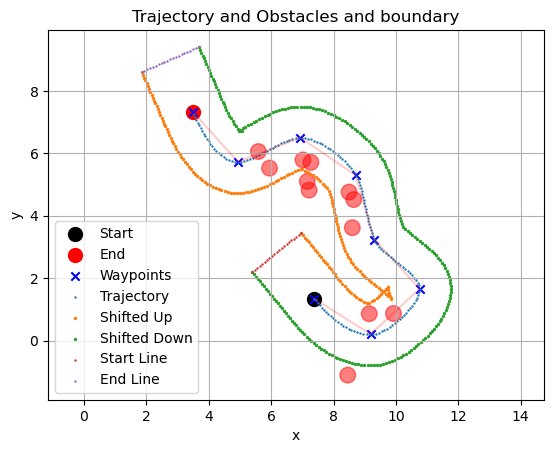

In [4]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import time
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from scipy.spatial import cKDTree
from shapely.geometry import Polygon, Point, LineString


starttime = time.time()
class Path():
    def __init__(self,
                 trajectory_point_interval=0.1,
                 No=12,
                 Nw=8,
                 Lp=15,
                 mu_r=0.25,
                 sigma_d=0.8,
                 shift_distance=5,
                 extend_length = 2):
        
        self.interval = trajectory_point_interval
        self.No=No
        self.Nw=Nw
        self.Lp=Lp
        self.mu_r=mu_r
        self.sigma_d=sigma_d
        
        self.shift_distance = shift_distance
        self.extend_length = extend_length
        
    def generate_waypoints_not_back(self, Nw, Lp):
        """
        This method generates random waypoints that won't go back
        """
        # Generate the starting point
        theta_start = np.random.uniform(0, 2 * np.pi)
        p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
        waypoints = [p_start]

        # Calculate the average segment length
        avg_segment_length = Lp / (Nw - 1)

        # Generate the remaining waypoints
        for i in range(1, Nw):  # Nw - 1 to leave space for the last waypoint (p_end)
            # Get the previous waypoint and the direction of the previous segment
            prev_waypoint = waypoints[-1]
            if i == 1:
                prev_dir = np.array([1, 0])
            else:
                prev_dir = prev_waypoint - waypoints[-2]
            
            # Generate a new waypoint in the forward direction
            while True:
                # Generate a random direction vector
                direction = np.random.rand(2) - 0.5
                direction /= np.linalg.norm(direction)

                # Check if the new waypoint is in the forward direction
                if np.dot(direction, prev_dir) >= 0:
                    break
            
            # Generate a new waypoint at the average segment length and add it to the list
            new_waypoint = prev_waypoint + avg_segment_length * direction
            waypoints.append(new_waypoint)

        self.waypoints =  np.array(waypoints)

    def generate_path_colav_environment(self, No, Nw, Lp, mu_r, sigma_d):
    
        # Create smooth arc length parameterized path using PCHIP
        p = interp.PchipInterpolator(np.linspace(0, 1, Nw), self.waypoints, axis=0)

        obstacles = []

        # Generate No obstacles
        for _ in range(No):
            # Draw arclength omega_obst from Uniform(0.1 * Lp, 0.9 * Lp)
            omega_obst = np.random.uniform(0.1 * Lp, 0.9 * Lp)

            # Map omega_obst to normalized arclength
            norm_omega_obst = omega_obst / Lp

            # Draw obstacle displacement distance d_obst from N(0, sigma_d^2)
            d_obst = np.random.normal(0, sigma_d**2)

            # Path angle gamma_obst
            gamma_obst = np.arctan2(p.derivative()(norm_omega_obst)[1], p.derivative()(norm_omega_obst)[0])

            # Obstacle position
            p_obst = p(norm_omega_obst) + d_obst * np.array([np.cos(gamma_obst - np.pi/2), np.sin(gamma_obst - np.pi/2)])

            # Draw obstacle radius r_obst from Poisson(mu_r)
            # r_obst = np.clip(np.random.normal(mu_r, 0.3), 0.1, 1)
            r_obst = mu_r # temporary using a fix radius
            # Add obstacle (p_obst, r_obst) to environment
            obstacles.append((p_obst, r_obst))

        return p, obstacles
    
    def arc_length(self, path, t, dt):
        derivative = path.derivative()(t)
        return np.sqrt(np.sum(derivative**2, axis=1)) * dt
    
    def generate_path(self):
        self.generate_waypoints_not_back(self.Nw, self.Lp)
        path, self.obstacles = self.generate_path_colav_environment(self.No, self.Nw, self.Lp, self.mu_r, self.sigma_d)
        # Calculate even trajectory points
        t = np.linspace(0, 1, 1000)
        dt = t[1] - t[0]
        cumulative_arclength = np.cumsum(self.arc_length(path, t, dt))
        point_distance = 0.1
        total_arclength = cumulative_arclength[-1]
        num_points = int(np.ceil(total_arclength / point_distance))
        even_t = np.zeros(num_points)
        current_arclength = 0
        for i in range(1, num_points):
            current_arclength += point_distance
            even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
        self.even_trajectory = path(even_t)

        # Calculate yaw angles at each point
        path_derivative = path.derivative()(even_t)
        self.yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])
    
    def generate_walls(self):
        """
        Generate the boundary of the environment
        """
        points = self.even_trajectory.copy()
        # Shift the trajectories
        shifted_points_up, shifted_points_down = self.shift_trajectory_local(points, self.shift_distance)
        # Smooth and resample the shifted trajectories
        target_distance = 0.1
        resampled_shifted_points_up, resampled_shifted_points_down = self.smooth_and_resample_trajectories(shifted_points_up, shifted_points_down, target_distance)

        # Extend the resampled trajectories
        extend_length = 2
        extended_resampled_shifted_points_up = self.extend_trajectory(resampled_shifted_points_up, extend_length)
        extended_resampled_shifted_points_down = self.extend_trajectory(resampled_shifted_points_down, extend_length)

        # Create lines connecting the starting points and ending points
        start_line = self.create_line_between_points(extended_resampled_shifted_points_up[0], extended_resampled_shifted_points_down[0], point_distance=0.1)
        end_line = self.create_line_between_points(extended_resampled_shifted_points_up[-1], extended_resampled_shifted_points_down[-1], point_distance=0.1)
        
        self.wall_up = extended_resampled_shifted_points_up
        self.wall_down = extended_resampled_shifted_points_down
        self.start_line = start_line
        self.end_line = end_line
        
        # This list is for the normal distance calculation
        # Yeah I know it looks ugly and provides identical information with the walls_kdTree
        # May tune it in the furture
        self.walls = [self.wall_up, self.wall_down, self.start_line, self.end_line]
        self.generate_kdTree_attributes()
        self.bounding_box_polygon = Polygon(self.walls_stack)

    def generate_kdTree_attributes(self):
        self.walls_stack = np.vstack([self.wall_up, self.wall_down, self.start_line, self.end_line])
        self.starting_indices = [0, len(self.wall_up), 
                    len(self.wall_up) + len(self.wall_down), 
                    len(self.wall_up) + len(self.wall_down) + len(self.start_line)]
        self.kd_tree = cKDTree(self.walls_stack)
        
    def local_orthogonal_directions(self, points):
        diff = np.diff(points, axis=0)
        normalized_diff = diff / np.linalg.norm(diff, axis=1, keepdims=True)
        orthogonal_directions = np.array([-normalized_diff[:, 1], normalized_diff[:, 0]]).T
        return orthogonal_directions

    def shift_trajectory_local(self, points, distance, num_points=None):
        orthogonal_directions = self.local_orthogonal_directions(points)
        # Repeat the last orthogonal direction for the last point
        orthogonal_directions = np.vstack([orthogonal_directions, orthogonal_directions[-1, :]])
        shifted_points_up = points + distance * orthogonal_directions
        shifted_points_down = points - distance * orthogonal_directions

        if num_points is None:
            num_points = len(points)

        # Interpolate the shifted points to maintain even separation
        t_original = np.linspace(0, 1, len(points))
        t_new = np.linspace(0, 1, num_points)

        interpolator_up = interp1d(t_original, shifted_points_up, axis=0, kind='linear')
        interpolated_shifted_points_up = interpolator_up(t_new)

        interpolator_down = interp1d(t_original, shifted_points_down, axis=0, kind='linear')
        interpolated_shifted_points_down = interpolator_down(t_new)

        return interpolated_shifted_points_up, interpolated_shifted_points_down

    def smooth_and_resample_trajectories(self, trajectory1, trajectory2, target_distance):
        """
        Smooth and resample the walls
        """
        def resample_trajectory(trajectory, target_distance):
            # Compute the distances between consecutive points
            distances = np.sqrt(np.sum(np.diff(trajectory, axis=0)**2, axis=1))
            # Compute the cumulative distance along the trajectory
            cum_dist = np.concatenate(([0], np.cumsum(distances)))
            total_distance = cum_dist[-1]

            # Calculate the number of new points for the resampled trajectory
            num_points = int(np.ceil(total_distance / target_distance))
            t_new = np.linspace(0, total_distance, num_points)

            # Interpolate the trajectory using cubic splines
            spline = CubicSpline(cum_dist, trajectory)
            resampled_trajectory = spline(t_new)

            return resampled_trajectory
        
        # Resample both trajectories with the target distance
        resampled_trajectory1 = resample_trajectory(trajectory1, target_distance)
        resampled_trajectory2 = resample_trajectory(trajectory2, target_distance)

        return resampled_trajectory1, resampled_trajectory2
    
    def extend_trajectory(self, points, extend_length):
        distance = np.linalg.norm(points[3] - points[2])
        start_direction = (points[1] - points[0]) / np.linalg.norm(points[1] - points[0])
        end_direction = (points[-1] - points[-2]) / np.linalg.norm(points[-1] - points[-2])
        num_points_to_add = int(extend_length / distance)
        start_points = [points[0] - start_direction * distance * i for i in range(1, num_points_to_add + 1)][::-1]
        end_points = [points[-1] + end_direction * distance * i for i in range(1, num_points_to_add + 1)]

        return np.vstack([start_points, points, end_points])

    def create_line_between_points(self, point_a, point_b, point_distance=0.1):
        distance = np.linalg.norm(point_b - point_a)
        num_points = int(np.ceil(distance / point_distance)) + 1
        t = np.linspace(0, 1, num_points)
        line_points = np.array([(1 - t_i) * point_a + t_i * point_b for t_i in t])
        return line_points

    def minimum_distance_to_walls(self, point, method: str = 'kdtree'):
        """
        Return the minimum distance to the nearest wall and that closest point
        
        ### Parameters
        - `point`: np.array([x, y])
        - `method`: str, 'kdtree' or 'normal'
        
        ### Returns
        - `min_distance`: float
        - `closest_point`: np.array([x, y])
        """
        if method == 'kdtree':
            min_distance, index = self.kd_tree.query(point)
            closest_trajectory_index = np.searchsorted(self.starting_indices, index, side="right") - 1
            closest_point_index = index - self.starting_indices[closest_trajectory_index]
            return min_distance, self.walls[closest_trajectory_index][closest_point_index]
            # print(f"kdtree: {min_distance, self.walls[closest_trajectory_index][closest_point_index]}")
        elif method=='normal':        
            min_distance = float('inf')
            closest_trajectory_index = -1
            closest_point_index = -1

            for i, trajectory in enumerate(self.walls):
                distances = np.linalg.norm(trajectory - point, axis=1)
                current_min_distance = np.min(distances)
                current_closest_point_index = np.argmin(distances)

                if current_min_distance < min_distance:
                    min_distance = current_min_distance
                    closest_trajectory_index = i
                    closest_point_index = current_closest_point_index
            # print(f"noraml way: {min_distance, self.walls[closest_trajectory_index][closest_point_index]}")
            return min_distance, self.walls[closest_trajectory_index][closest_point_index]
    
    def is_inside(self, point):
        """
        Check if a point is inside the boundary
        
        ### Parameters
        point: np.array([x, y])
        
        ### Returns
        is_inside: bool
        
        ### Example
        >>> point = np.array([0, 0])
        >>> is_inside = self.is_inside(point)
        """
        is_inside = self.bounding_box_polygon.contains(Point(point))
        return is_inside
    
    def is_crossed(self):
        line1 = LineString(self.even_trajectory)
        line2 = LineString(self.wall_up)
        line3 = LineString(self.wall_down)
        line4 = LineString(self.start_line)
        line5 = LineString(self.end_line)

        trajectory1 = [line1, line2, line3]
        trajectory2 = [line1, line4, line5]
        crossing = False
        for i in range(len(trajectory1)):
            for j in range(i + 1, len(trajectory1)):
                if trajectory1[i].intersects(trajectory1[j]):
                    crossing = True
                    break
            if crossing:
                break
            
        for i in range(len(trajectory2)):
            for j in range(i + 1, len(trajectory2)):
                if trajectory2[i].intersects(trajectory2[j]):
                    crossing = True
                    break
            if crossing:
                break
        return crossing
        
    def render(self):
        # plot waypoints
        plt.scatter(self.waypoints[0,0], self.waypoints[0,1], s=100, c='k',  label="Start")
        plt.scatter(self.waypoints[-1,0], self.waypoints[-1,1], s=100, c='r', label="End")
        plt.scatter(self.waypoints[:, 0], self.waypoints[:, 1], c='b', marker='x',label="Waypoints")
        plt.plot(self.waypoints[:, 0], self.waypoints[:, 1], 'r', alpha=0.2)
        
        # Plot the trajectory
        plt.scatter(self.even_trajectory[:, 0], self.even_trajectory[:, 1], s=2, marker='.', label="Trajectory")
        
        for p_obst, r_obst in self.obstacles:
            circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        # Plot the trajectories
        plt.scatter(self.wall_up[:, 0], self.wall_up[:, 1], s=2, marker='o', label='Shifted Up')
        plt.scatter(self.wall_down[:, 0], self.wall_down[:, 1], s=2, marker='o', label='Shifted Down')

        # plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
        # plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

        plt.scatter(self.start_line[:, 0], self.start_line[:, 1], s=2, marker='.', label='Start Line')
        plt.scatter(self.end_line[:, 0], self.end_line[:, 1], s=2, marker='.', label='End Line')

        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Trajectory and Obstacles and boundary")
        plt.axis("equal")
        plt.grid()
    
    def print_shape(self):
        print(f"shape of waypoints: {self.waypoints.shape}")
        print(f"shape of even_trajectory: {self.even_trajectory.shape}")
        print(f"shape of yaw_angles: {self.yaw_angles.shape}")
        print(f"shape of obstacles: {len(self.obstacles)}")
        print(f"shape of walls: {self.wall_up.shape}")
        # print("")
    
    def reset(self):
        self.generate_path()
        self.generate_walls()
        if self.is_crossed():
            self.reset()
        
        
testPath = Path(trajectory_point_interval=0.1,
                No=12, Nw=8, Lp=15, mu_r=0.25, sigma_d=0.8, shift_distance=1)
testPath.reset()
testPath.render()
testPath.print_shape()
endtime = time.time()
print(f"Time used: {endtime - starttime}")

# atr_position = np.array([testPath.waypoints[3,0], testPath.waypoints[3, 1]])
# print(atr_position)
# min_distance, closest_point = testPath.minimum_distance_to_walls(atr_position)
# plt.scatter(atr_position[0], atr_position[1], s=100, marker='+', label='Query Point')
# plt.scatter(closest_point[0], closest_point[1], s=50, marker='+', label='Closest Point')


In [230]:
from shapely.geometry import Polygon, Point, LineString
new_trajectory_1 = testPath.even_trajectory
new_trajectory_2 = testPath.wall_up
new_trajectory_3 = testPath.wall_down
new_trajectory_4 = testPath.start_line
new_trajectory_5 = testPath.end_line

line1 = LineString(new_trajectory_1)
line2 = LineString(new_trajectory_2)
line3 = LineString(new_trajectory_3)
line4 = LineString(new_trajectory_4)
line5 = LineString(new_trajectory_5)

trajectory1 = [line1, line2, line3]
trajectory2 = [line1, line4, line5]
# Iterate through all possible pairs of trajectories
crossing = False
for i in range(len(trajectory1)):
    for j in range(i + 1, len(trajectory1)):
        if trajectory1[i].intersects(trajectory1[j]):
            crossing = True
            break
    if crossing:
        break
    
for i in range(len(trajectory2)):
    for j in range(i + 1, len(trajectory2)):
        if trajectory2[i].intersects(trajectory2[j]):
            crossing = True
            break
    if crossing:
        break
print("Do any two trajectories cross?", crossing)


Do any two trajectories cross? False


In [163]:
sample_indexs = np.random.choice(testPath.even_trajectory.shape[0], 2000)
query_points = testPath.even_trajectory[sample_indexs] + np.random.normal(0, 0.4, size=(2000, 2))

In [164]:
starttime = time.time()
for point in query_points:
    min_distance, closest_point = testPath.minimum_distance_to_walls(point)
endtime = time.time()
print(f"Time used: {endtime - starttime}")

Time used: 0.13954687118530273


In [165]:
starttime = time.time()
for point in query_points:
    min_distance, closest_point = testPath.minimum_distance_to_walls(point, 'normal')
endtime = time.time()
print(f"Time used: {endtime - starttime}")

Time used: 0.3975870609283447


## Cheeck if a point is inside the polygon

In [180]:
from shapely.geometry import Polygon, Point
bounding_box_polygon = Polygon(np.vstack([testPath.wall_up, testPath.wall_down, testPath.start_line, testPath.end_line]))
point = np.array([-4, -5])
isinside = testPath.is_inside(point)
if isinside:
    print("inside")
else:
    print("outside")

outside


In [5]:
walls = [testPath.wall_up, testPath.wall_down, testPath.start_line, testPath.end_line]
walls_kdTree = np.vstack([testPath.wall_up, testPath.wall_down, testPath.start_line, testPath.end_line])
# print(walls)
# print(walls_kdTree)

Computation time: 0.00184 seconds
Computation time: 0.00281 seconds


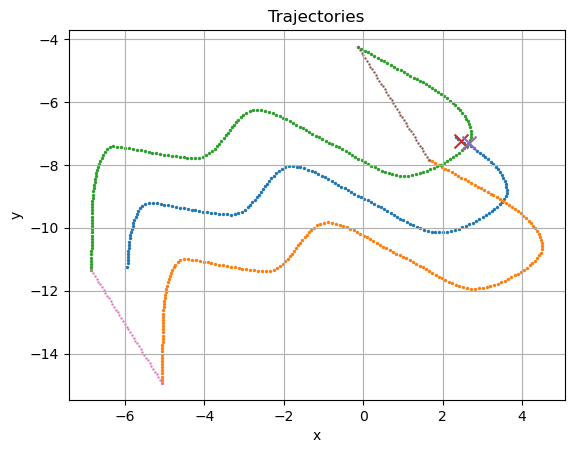

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import time

def average_direction(points):
    diff = np.diff(points, axis=0)
    avg_dir = np.mean(diff, axis=0)
    return avg_dir / np.linalg.norm(avg_dir)

def orthogonal_vector(vector):
    return np.array([-vector[1], vector[0]])

def shift_trajectory(points, distance, direction):
    return points + distance * direction

def distance_to_trajectories(point, trajectories):
    min_distance = float('inf')
    closest_trajectory = -1
    closest_point_index = -1

    for i, trajectory in enumerate(trajectories):
        distances = np.linalg.norm(trajectory - point, axis=1)
        current_min_distance = np.min(distances)
        current_closest_point_index = np.argmin(distances)

        if current_min_distance < min_distance:
            min_distance = current_min_distance
            closest_trajectory = i
            closest_point_index = current_closest_point_index

    return min_distance, closest_trajectory, closest_point_index

def extend_trajectory(points, extend_length):
    
    if extend_length == 0:
        return points
    
    distance = np.linalg.norm(points[3] - points[2])
    start_direction = (points[1] - points[0]) / np.linalg.norm(points[1] - points[0])
    end_direction = (points[-1] - points[-2]) / np.linalg.norm(points[-1] - points[-2])
    num_points_to_add = int(extend_length / distance)
    start_points = [points[0] - start_direction * distance * i for i in range(1, num_points_to_add + 1)][::-1]
    end_points = [points[-1] + end_direction * distance * i for i in range(1, num_points_to_add + 1)]

    return np.vstack([start_points, points, end_points])

def create_line_between_points(point_a, point_b, point_distance=0.1):
    distance = np.linalg.norm(point_b - point_a)
    num_points = int(np.ceil(distance / point_distance)) + 1
    t = np.linspace(0, 1, num_points)
    line_points = np.array([(1 - t_i) * point_a + t_i * point_b for t_i in t])
    return line_points

# Example usage:
# points = np.array([(0, 0), (1, 1), (2, 0), (3, 1), (4, 0)])
points = testPath.even_trajectory.copy()

distance = 2

avg_dir = average_direction(points)
orthogonal_dir = orthogonal_vector(avg_dir)

shifted_points_up = shift_trajectory(points, distance, orthogonal_dir)
shifted_points_down = shift_trajectory(points, -distance, orthogonal_dir)

# Extend the trajectories
extend_length = 2
extended_shifted_points_up = extend_trajectory(shifted_points_up, extend_length)
extended_shifted_points_down = extend_trajectory(shifted_points_down, extend_length)

# Create lines connecting the starting points and ending points
start_line = create_line_between_points(extended_shifted_points_up[0], extended_shifted_points_down[0], point_distance=0.1)
end_line = create_line_between_points(extended_shifted_points_up[-1], extended_shifted_points_down[-1], point_distance=0.1)




# Closest point
sample_indexs = np.random.choice(points.shape[0], 20)
query_points = points[sample_indexs]

trajectories = [extended_shifted_points_up, extended_shifted_points_down, start_line, end_line]
# query_point = np.array([0.0, 0.0])
start_time = time.time()
for query_point in query_points:
    min_distance, closest_trajectory_index, closest_point_index = distance_to_trajectories(query_point, trajectories)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time:.5f} seconds")


# Closet point using cKDTree
start_time = time.time()
all_new_trajectories = np.vstack([extended_shifted_points_up, extended_shifted_points_down, start_line, end_line])
# Store the starting indices of each trajectory in the combined array
starting_indices = [0, len(extended_shifted_points_up), 
                    len(extended_shifted_points_up) + len(extended_shifted_points_down), 
                    len(extended_shifted_points_up) + len(extended_shifted_points_down) + len(start_line)]
# Create a k-d tree
kd_tree = cKDTree(all_new_trajectories)
for query_point in query_points:
    # Query the k-d tree for the nearest point
    min_distance, index = kd_tree.query(query_point)
    closest_trajectory_index = np.searchsorted(starting_indices, index, side="right") - 1
    closest_point_index = index - starting_indices[closest_trajectory_index]
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time:.5f} seconds")

# Plot the trajectories
plt.scatter(points[:, 0], points[:, 1], s=2, marker='o', label='Original')
plt.scatter(extended_shifted_points_up[:, 0], extended_shifted_points_up[:, 1], s=2, marker='o', label='Shifted Up')
plt.scatter(extended_shifted_points_down[:, 0], extended_shifted_points_down[:, 1], s=2, marker='o', label='Shifted Down')

plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

plt.scatter(start_line[:, 0], start_line[:, 1], s=2, marker='.', label='Start Line')
plt.scatter(end_line[:, 0], end_line[:, 1], s=2, marker='.', label='End Line')

# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.grid()
plt.show()

In [92]:
points = testPath.even_trajectory.copy()
distance = 1

In [93]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz

def local_orthogonal_directions(points):
    diff = np.diff(points, axis=0)
    normalized_diff = diff / np.linalg.norm(diff, axis=1, keepdims=True)
    orthogonal_directions = np.array([-normalized_diff[:, 1], normalized_diff[:, 0]]).T
    return orthogonal_directions

def shift_trajectory_local(points, distance, num_points=None):
    orthogonal_directions = local_orthogonal_directions(points)
    # Repeat the last orthogonal direction for the last point
    orthogonal_directions = np.vstack([orthogonal_directions, orthogonal_directions[-1, :]])
    shifted_points_up = points + distance * orthogonal_directions
    shifted_points_down = points - distance * orthogonal_directions

    if num_points is None:
        num_points = len(points)

    # Interpolate the shifted points to maintain even separation
    t_original = np.linspace(0, 1, len(points))
    t_new = np.linspace(0, 1, num_points)

    interpolator_up = interp1d(t_original, shifted_points_up, axis=0, kind='linear')
    interpolated_shifted_points_up = interpolator_up(t_new)

    interpolator_down = interp1d(t_original, shifted_points_down, axis=0, kind='linear')
    interpolated_shifted_points_down = interpolator_down(t_new)

    return interpolated_shifted_points_up, interpolated_shifted_points_down

def smooth_and_resample_trajectories(trajectory1, trajectory2, target_distance):
    def resample_trajectory(trajectory, target_distance):
        # Compute the distances between consecutive points
        distances = np.sqrt(np.sum(np.diff(trajectory, axis=0)**2, axis=1))
        # Compute the cumulative distance along the trajectory
        cum_dist = np.concatenate(([0], np.cumsum(distances)))
        total_distance = cum_dist[-1]

        # Calculate the number of new points for the resampled trajectory
        num_points = int(np.ceil(total_distance / target_distance))
        t_new = np.linspace(0, total_distance, num_points)

        # Interpolate the trajectory using cubic splines
        spline = CubicSpline(cum_dist, trajectory)
        resampled_trajectory = spline(t_new)

        return resampled_trajectory

    # Resample both trajectories with the target distance
    resampled_trajectory1 = resample_trajectory(trajectory1, target_distance)
    resampled_trajectory2 = resample_trajectory(trajectory2, target_distance)

    return resampled_trajectory1, resampled_trajectory2

# Shift the trajectories
shifted_points_up, shifted_points_down = shift_trajectory_local(points, distance)

# Smooth and resample the shifted trajectories
target_distance = 0.1
resampled_shifted_points_up, resampled_shifted_points_down = smooth_and_resample_trajectories(shifted_points_up, shifted_points_down, target_distance)

# Extend the resampled trajectories
extend_length = 2
extended_resampled_shifted_points_up = extend_trajectory(resampled_shifted_points_up, extend_length)
extended_resampled_shifted_points_down = extend_trajectory(resampled_shifted_points_down, extend_length)

# Create lines connecting the starting points and ending points
start_line = create_line_between_points(extended_resampled_shifted_points_up[0], extended_resampled_shifted_points_down[0], point_distance=0.1)
end_line = create_line_between_points(extended_resampled_shifted_points_up[-1], extended_resampled_shifted_points_down[-1], point_distance=0.1)


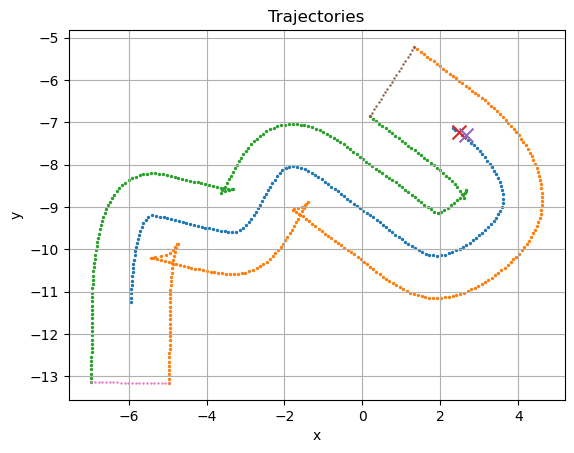

In [94]:
plt.scatter(points[:, 0], points[:, 1], s=2, marker='o', label='Original')
plt.scatter(extended_resampled_shifted_points_up[:, 0], extended_resampled_shifted_points_up[:, 1], s=2, marker='o', label='Shifted Up')
plt.scatter(extended_resampled_shifted_points_down[:, 0], extended_resampled_shifted_points_down[:, 1], s=2, marker='o', label='Shifted Down')

plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

plt.scatter(start_line[:, 0], start_line[:, 1], s=2, marker='.', label='Start Line')
plt.scatter(end_line[:, 0], end_line[:, 1], s=2, marker='.', label='End Line')

# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.grid()
plt.show()


In [95]:
print(extended_resampled_shifted_points_up.shape)

(228, 2)
